# Visualizing COVID-19 Data

This notebook is a small collection of examples on visualizing data of the ongoing pandemic of COVID-19. Data is pulled from [this repository](https://github.com/CSSEGISandData/COVID-19) which is updated regularly by the [Whiting School of Engineering of the Johns Hopkins University](https://systems.jhu.edu/research/public-health/ncov/).

## Getting Started
First, you need to get the repository this repository. You can either download it by [clicking here](https://github.com/aquilesC/Covid-19-Jupyter-Notebook/archive/master.zip) or by running the following on your terminal:

```bash
git clone git@github.com:aquilesC/Covid-19-Jupyter-Notebook.git Covid
```

The Data folder is actually another repository, pointing to the John Hopkins repository, therefore, you will need to enter into the ``Covid`` folder and do the following:

```bash
git submodule update --init --recursive
``` 
This will pull the data. Since the repository gets updated twice each day, before running the notebook, you should update the data by running the following, again directly from within the ``Covid`` folder:
```bash
git submodule update --recursive --remote
```

## Importing the modules

In [1]:
from datetime import datetime
import numpy as np
import os
import pandas as pd

We can now define the style of our plots. I like making big images with large fonts for axis to increase readability. I'm also setting the style to ``ggplot`` just to make different from standard matplotlib plots, but not because I particularly like it.

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams["figure.figsize"] = (13,8)
plt.style.use('ggplot')
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['font.size'] = 16

## Saving figures
I will use the parameter below to save the figures generated in this notebook. Every time a figure is generated, there will be an extra if-statement. This is useful when running the entire notebook just to make a new version of the plots with the data available

In [3]:
SAVE_FIGURES = True
# We store the Figures in one folder
if SAVE_FIGURES and not os.path.isdir('Figures'):
    os.makedirs('Figures')

## Data sources
We define the path to the files with the information we are interested int. I am using just the time series data which has the same information than the daily reports but aggregated. It also uses the cumulative numbers instead of the numbers of new cases. 

Starting **March 24th 2020**, they stopped providing updates to the number of recoveries, therefore we will need to rely only on the cummulative number of detected cases.

In [4]:
base_path = 'Data/csse_covid_19_data/csse_covid_19_time_series'
confirmed_file = os.path.join(base_path, 'time_series_covid19_confirmed_global.csv')
deaths_file = os.path.join(base_path, 'time_series_covid19_deaths_global.csv')

## Standardizing the data
We are going to load three different data sources: confirmed cases, deaths and recoveries. They all have the same format and we will apply some basic transofrmations to all the files. Hence, we abstract this to a function which is easier to maintain. 

We read the file (a csv file). We are not interested in the specific regions, but in studying trends at a country-level. We drop the columns with that information and also with the latitude/longitude coordinates, since we won't use them. Some countries have data split by state, such as in the case of China, and therefore we need to add it all up. Finally, the data is arranged in columns with the date, we transpose the dataframe in order to make it easier to work with. The final step is only transforming the index of the table to actual dates. 

In [5]:
def read_data_file(filename):
    data = pd.read_csv(filename)
    data = data.drop(['Province/State', 'Lat', 'Long'], axis=1)
    data = data.groupby(['Country/Region']).sum().transpose()
    data.index = pd.to_datetime(data.index)
    return data

In [6]:
confirmed_data = read_data_file(confirmed_file)
deaths_data = read_data_file(deaths_file)

The ``confirmed_data`` is the cumulative number of detected cases. However, it is much easier to understand if we only work with the number of new cases. For example, if we plot cumulative cases, the curve will never go down. At best, it will flatten out once no new cases appear. This is counter intuitive for most people. 

Therefore, we transform the confirmed number of cases to the differences betwen consecutive days. This gives just the number of new cases detected in every country.

In [7]:
sick_data = confirmed_data

## China
Let's see the information we have on China. Since we are plotting only one country, it is important to add the title, so we know what we are seeing. For more countries, the legend will do the job fine. 

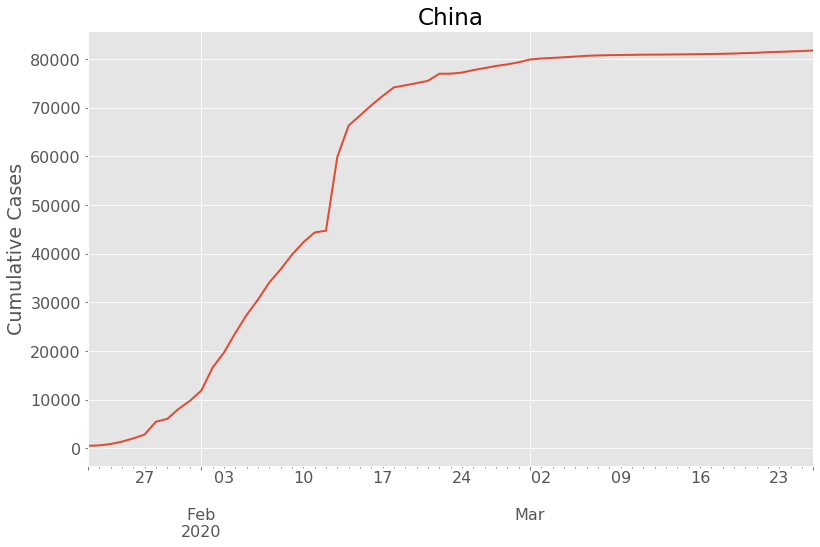

In [8]:
ax = sick_data['China'].plot(title='China')
ax.set_ylabel('Cumulative Cases')
if SAVE_FIGURES:
    plt.savefig('Figures/China_Lin_Lin.png')

With China we see the rapid growth of infections at the beginning of the year and how it declined in the last weeks. However, since the data spawns a lot of ranges (from close to 0 to almost 60000), it can be better to plot in in logarithmic scale:

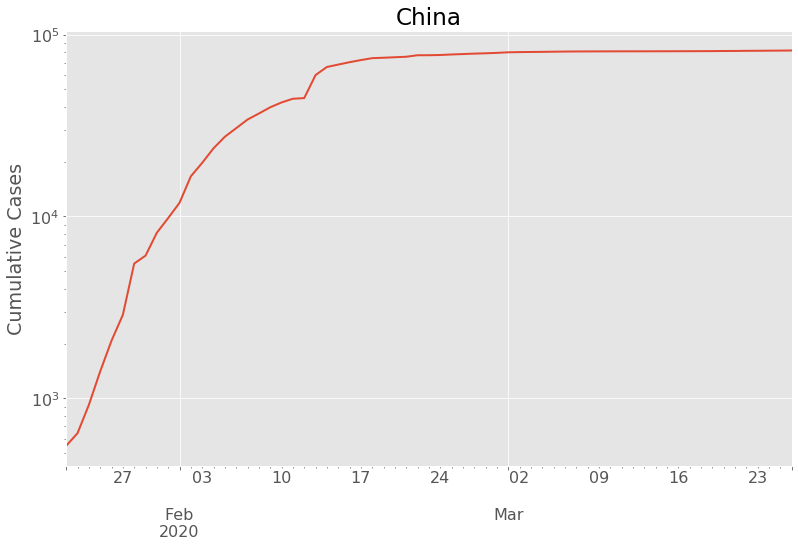

In [9]:
ax = sick_data['China'].plot(title='China', logy=True)
ax.set_ylabel('Cumulative Cases')
if SAVE_FIGURES:
    plt.savefig('Figures/China_Log_Lin.png')

## Comparing countries
Let's see how different countires compare over time. No normalizations, just the real data, in logarithmic scale.

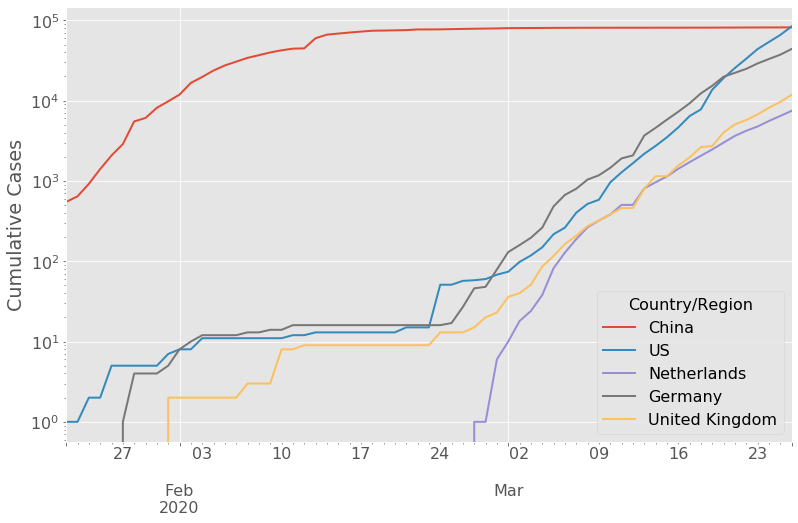

In [10]:
countries = ['China', 'US', 'Netherlands', 'Germany', 'United Kingdom']
ax = sick_data[countries].plot(logy=True)
ax.set_ylabel('Cumulative Cases')
if SAVE_FIGURES:
    plt.savefig('Figures/Country_comparison_log_lin.png')

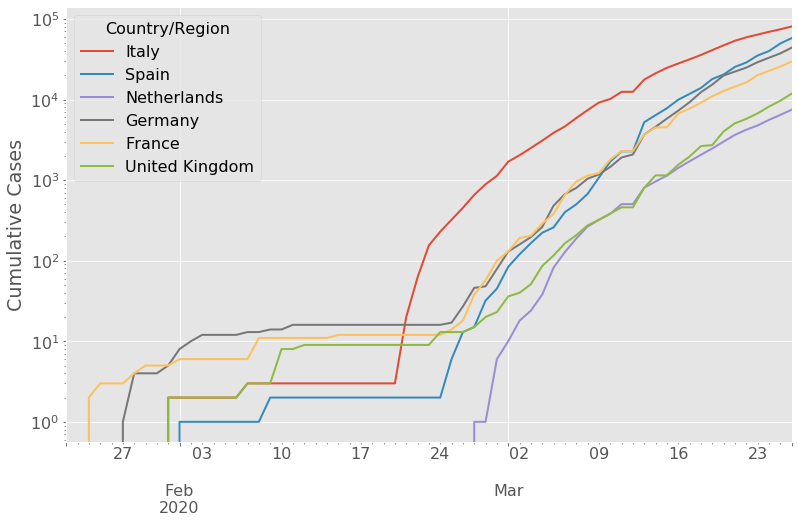

In [11]:
countries = ['Italy', 'Spain', 'Netherlands', 'Germany', 'France', 'United Kingdom']
ax = sick_data[countries].plot(logy=True)
ax.set_ylabel('Cumulative Cases')
if SAVE_FIGURES:
    plt.savefig('Figures/Europe_Log_Lin_01.png')

The trends above seem very similar but shifted by some days. We can try to make them overlap, in order to see if the trends are actually the same or if in some cases they are moving faster or slower. 

I will define the time shifts in a dictionary, to make them easier to edit and reuse in later parts of the code. I'm using **Italy** as a temporal reference because it is the country that was first hit very badly. 

In [12]:
time_shifts = {
    'Spain': 4,
    'Netherlands': 8,
    'Germany': 4,
    'United Kingdom': 6,
}

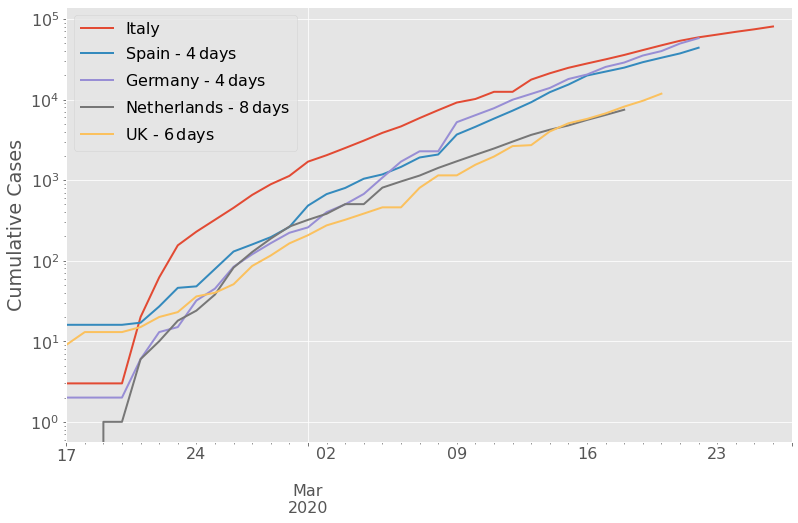

In [13]:
# Since I am altering the index in-place, each time I change the time-shift I need to copy the original data. 
italy = sick_data['Italy'].copy()
spain = sick_data['Spain'].copy()
germany = sick_data['Germany'].copy()
netherlands = sick_data['Netherlands'].copy()
uk = sick_data['United Kingdom'].copy()
spain.index -= pd.to_timedelta(time_shifts['Spain'], unit='d')
germany.index -= pd.to_timedelta(time_shifts['Germany'], unit='d')
netherlands.index -= pd.to_timedelta(time_shifts['Netherlands'], unit='d')
uk.index -= pd.to_timedelta(time_shifts['United Kingdom'], unit='d')
ax = italy.plot(logy=True)
germany.plot(ax=ax)
spain.plot(ax=ax)
netherlands.plot(ax=ax)
uk.plot(ax=ax)
ax.legend(['Italy', 
           f'Spain - {time_shifts["Spain"]}$\,$days', 
           f'Germany - {time_shifts["Germany"]}$\,$days', 
           f'Netherlands - {time_shifts["Netherlands"]}$\,$days',
           f'UK - {time_shifts["United Kingdom"]}$\,$days',
          ])
ax.set_xlim('2020-02-17', datetime.today())
ax.set_ylabel('Cumulative Cases')
if SAVE_FIGURES:
    plt.savefig('Figures/Europe_countries_shifted_log_lin.png')

We can also plot the lockdowns or quarentine measures in each country, taking into account the temporal shift of the previous plot. 

Since we are plotting  to the same axes, we lose control over the color cycle. Therefore, we can explicitly explore the color pallette and see which colors are being used. This is stored in ``plt.rcParams['axes.prop_cycle']``. Bear in mind that if you change the style of the plots, for example changing or removing the line ``plt.style.use('ggplot')``, the values below will also change and therefore the vertical lines will need to change as wel..

In [14]:
plt.rcParams['axes.prop_cycle']

'#E24A33'
'#348ABD'
'#988ED5'
'#777777'
'#FBC15E'
'#8EBA42'
'#FFB5B8'


In [15]:
lockdowns = {
    'Italy': datetime(2020, 3, 9),
    'Spain': datetime(2020, 3, 15),
    'Netherlands': datetime(2020, 3, 15),
    'Germany': datetime(2020, 3, 16),
    'Argentina': datetime(2020, 3, 20),
    'United Kingdom': datetime(2020, 3, 23),
}

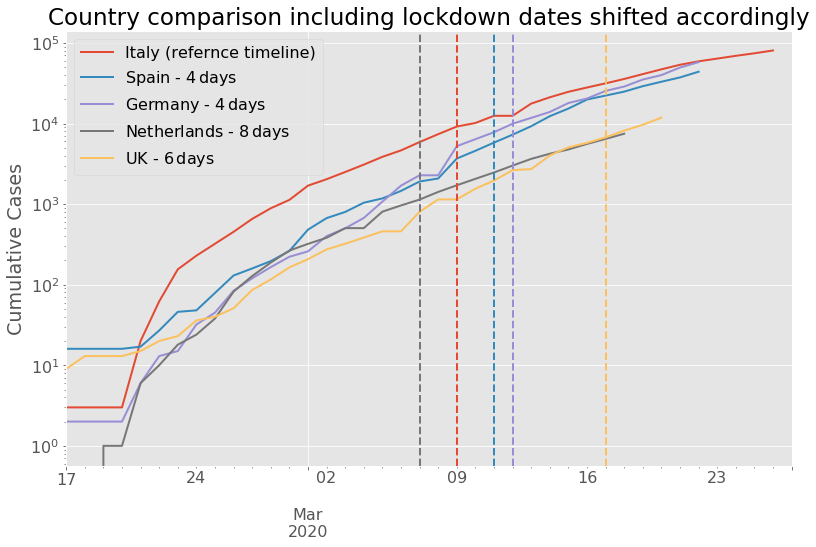

In [16]:
ax = italy.plot(logy=True, title='Country comparison including lockdown dates shifted accordingly')
germany.plot(ax=ax)
spain.plot(ax=ax)
netherlands.plot(ax=ax)
uk.plot(ax=ax)
ax.legend([
        'Italy (refernce timeline)', 
        f'Spain - {time_shifts["Spain"]}$\,$days', 
        f'Germany - {time_shifts["Germany"]}$\,$days', 
        f'Netherlands - {time_shifts["Netherlands"]}$\,$days',
        f'UK - {time_shifts["United Kingdom"]}$\,$days',
])
ax.set_xlim('2020-02-17', datetime.today())
ax.set_ylabel('Cumulative Cases')
ax.axvline(x=lockdowns['Italy'], linestyle='--')
ax.axvline(x=lockdowns['Spain']-pd.to_timedelta(time_shifts['Spain'], unit='d'), color='#348ABD', linestyle='--')
ax.axvline(x=lockdowns['Germany']-pd.to_timedelta(time_shifts['Germany'], unit='d'), color='#988ED5', linestyle='--')
ax.axvline(x=lockdowns['Netherlands']-pd.to_timedelta(time_shifts['Netherlands'], unit='d'), color='#777777', linestyle='--')
ax.axvline(x=lockdowns['United Kingdom']-pd.to_timedelta(time_shifts['United Kingdom'], unit='d'), color='#FBC15E', linestyle='--')
if SAVE_FIGURES:
    plt.savefig('Figures/Europe_countries_shifted_log_lin_with_lockdowns.png')

A lot of people struggle understanding semi-log plots, therefore, let's show the same data but in linear scale. 

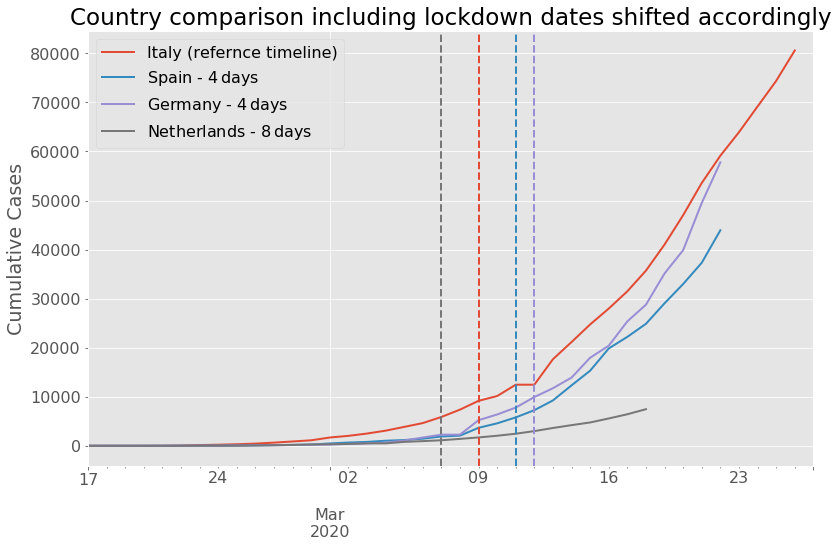

In [17]:
ax = italy.plot(logy=False, title='Country comparison including lockdown dates shifted accordingly')
germany.plot(ax=ax)
spain.plot(ax=ax)
netherlands.plot(ax=ax)
ax.legend(['Italy (refernce timeline)', 
           f'Spain - {time_shifts["Spain"]}$\,$days', 
           f'Germany - {time_shifts["Germany"]}$\,$days', 
           f'Netherlands - {time_shifts["Netherlands"]}$\,$days'])
ax.set_xlim('2020-02-17', datetime.today())
ax.set_ylabel('Cumulative Cases')
ax.axvline(x=lockdowns['Italy'], linestyle='--')
ax.axvline(x=lockdowns['Spain']-pd.to_timedelta(time_shifts['Spain'], unit='d'), color='#348ABD', linestyle='--')
ax.axvline(x=lockdowns['Germany']-pd.to_timedelta(time_shifts['Germany'], unit='d'), color='#988ED5', linestyle='--')
ax.axvline(x=lockdowns['Netherlands']-pd.to_timedelta(time_shifts['Netherlands'], unit='d'), color='#777777', linestyle='--')
if SAVE_FIGURES:
    plt.savefig('Figures/Europe_countries_shifted_lin_lin_with_lockdowns.png')

## Latin America
Some countries in Latin America are also interesting to observe. Mainly because they are following very different approaches to dealing with the virus. I'm also limiting the range of dates, because the first cases were detected relatively recently.

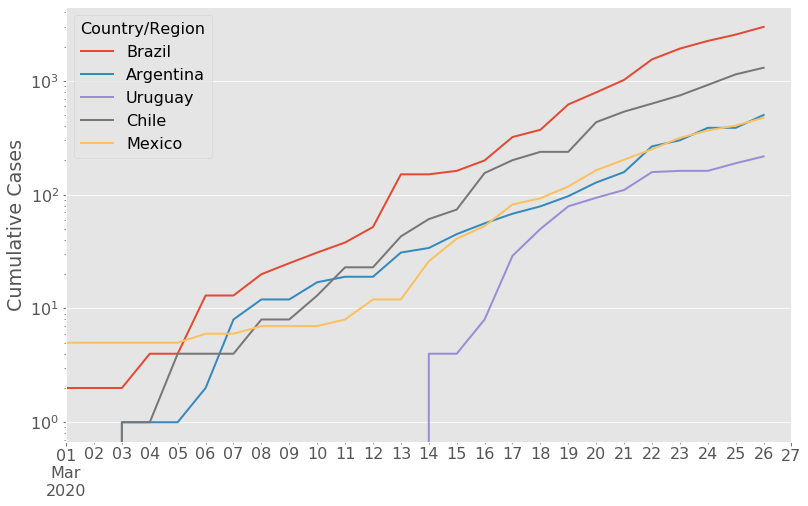

In [18]:
countries = ['Brazil', 'Argentina', 'Uruguay', 'Chile', 'Mexico']
ax = sick_data[countries].plot(logy=True)
ax.set_xlim('2020/03/01', datetime.today())
ax.set_ylabel('Cumulative Cases')
if SAVE_FIGURES:
    plt.savefig('Figures/Latin_America_Log_Lin.png')

We can see how Argentina compares to Italy regarding spread and lockdown

In [19]:
time_shifts.update({'Argentina': 16})

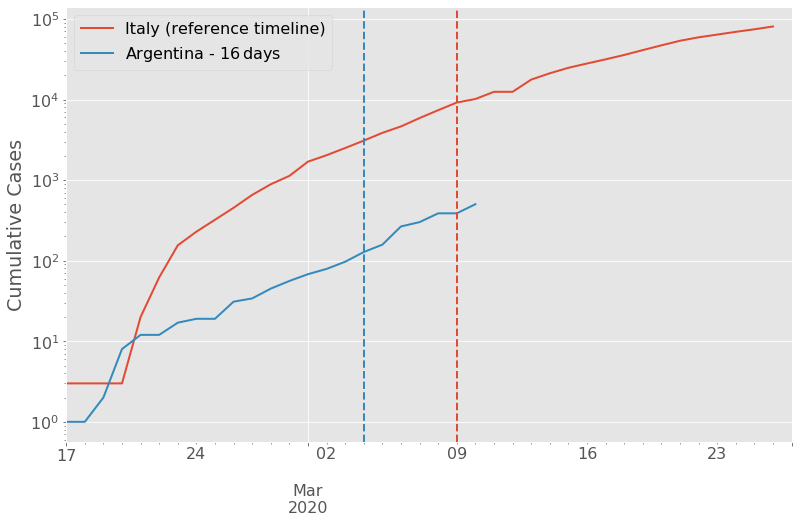

In [20]:
argentina = sick_data['Argentina'].copy()
argentina.index -= pd.to_timedelta(time_shifts['Argentina'], unit='d')
ax = italy.plot(logy=True)
argentina.plot(ax=ax)
ax.set_xlim('2020-02-17', datetime.today())
ax.legend([
    'Italy (reference timeline)',
    f'Argentina - {time_shifts["Argentina"]}$\,$days',
])
ax.axvline(x=lockdowns['Italy'], linestyle='--')
ax.axvline(x=lockdowns['Argentina']-pd.to_timedelta(time_shifts['Argentina'], unit='d'), color='#348ABD', linestyle='--')
ax.set_ylabel('Cumulative Cases')
if SAVE_FIGURES:
    plt.savefig('Figures/Argentina_Italy_log_lin_with_lockdowns.png')

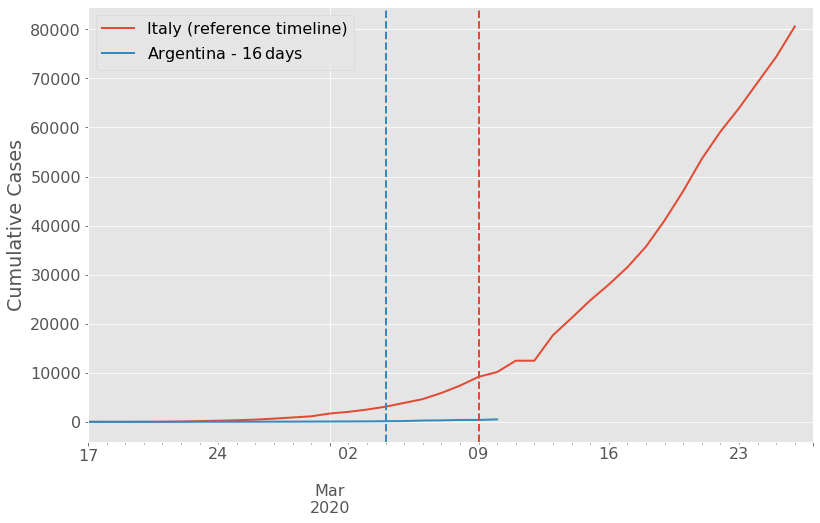

In [21]:
argentina = sick_data['Argentina'].copy()
argentina.index -= pd.to_timedelta(time_shifts['Argentina'], unit='d')
ax = italy.plot(logy=False)
argentina.plot(ax=ax)
ax.set_xlim('2020-02-17', datetime.today())
ax.legend([
    'Italy (reference timeline)',
    f'Argentina - {time_shifts["Argentina"]}$\,$days',
])
ax.axvline(x=lockdowns['Italy'], linestyle='--')
ax.axvline(x=lockdowns['Argentina']-pd.to_timedelta(time_shifts['Argentina'], unit='d'), color='#348ABD', linestyle='--')
ax.set_ylabel('Cumulative Cases')
if SAVE_FIGURES:
    plt.savefig('Figures/Argentina_Italy_lin_lin_with_lockdowns.png')

Finally, let's print the list of available countries so we know what other data we can explore.

## Fitting
Assuming the number of cases grows exponentially, can we actually learn something out of the fitting? 

#### Idea
Hopefully, the exponential growth will slow down. This can be seen if we fit past data and we show it over estimates present data. 

I try to do that in the cell below, but the results are far from easy to interpret. The fact that we get variable coefficients for variable lengths of data points considered (0 being 10 days ago) means that the exponential is not a good fit. However, this is not particularly representative, since while lock downs progress, testing tends to be more biased. 

Also, I may be using a range of dated too large (20 days in the past) which may include data before the onset of the epidemic and therefore prone to very large uncertainties. 

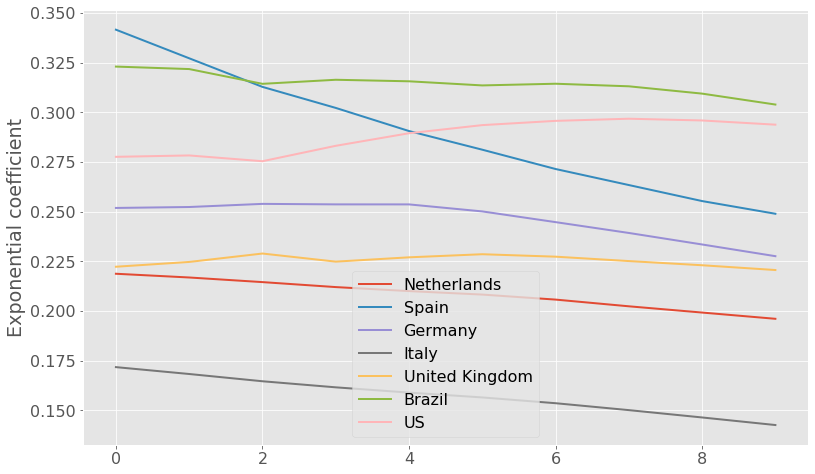

In [22]:
countries = ['Netherlands', 'Spain', 'Germany', 'Italy', 'United Kingdom', 'Brazil', 'US']

df = sick_data.copy()
df['days'] = sick_data.index - sick_data.index.min()
df['days'] = df['days'].apply(lambda x: int(x.days))

coeff = pd.DataFrame(columns=countries)
c = {country: [] for country in countries}
for i in range(10):
    for country in countries:
        p = np.polyfit(
            df['days'][len(sick_data)-20:len(sick_data)-10+i].array, 
            np.log10(df[country][len(sick_data)-20:len(sick_data)-10+i]).array,
            1,
        )
        c[country].append(p[0]*np.log(10.))
coeff = coeff.append(pd.DataFrame.from_dict(c))
ax = coeff.plot()
ax.set_xlabel('')
ax.set_ylabel('Exponential coefficient')
if SAVE_FIGURES:
    plt.savefig('Figures/Exponential_coefficients_several_countries.png')

In [23]:
list(confirmed_data)

['Afghanistan',
 'Albania',
 'Algeria',
 'Andorra',
 'Angola',
 'Antigua and Barbuda',
 'Argentina',
 'Armenia',
 'Australia',
 'Austria',
 'Azerbaijan',
 'Bahamas',
 'Bahrain',
 'Bangladesh',
 'Barbados',
 'Belarus',
 'Belgium',
 'Belize',
 'Benin',
 'Bhutan',
 'Bolivia',
 'Bosnia and Herzegovina',
 'Brazil',
 'Brunei',
 'Bulgaria',
 'Burkina Faso',
 'Cabo Verde',
 'Cambodia',
 'Cameroon',
 'Canada',
 'Central African Republic',
 'Chad',
 'Chile',
 'China',
 'Colombia',
 'Congo (Brazzaville)',
 'Congo (Kinshasa)',
 'Costa Rica',
 "Cote d'Ivoire",
 'Croatia',
 'Cuba',
 'Cyprus',
 'Czechia',
 'Denmark',
 'Diamond Princess',
 'Djibouti',
 'Dominica',
 'Dominican Republic',
 'Ecuador',
 'Egypt',
 'El Salvador',
 'Equatorial Guinea',
 'Eritrea',
 'Estonia',
 'Eswatini',
 'Ethiopia',
 'Fiji',
 'Finland',
 'France',
 'Gabon',
 'Gambia',
 'Georgia',
 'Germany',
 'Ghana',
 'Greece',
 'Grenada',
 'Guatemala',
 'Guinea',
 'Guinea-Bissau',
 'Guyana',
 'Haiti',
 'Holy See',
 'Honduras',
 'Hungary'